In [2]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [3]:
import database
reload(database)
db = database.thomas_18_db

In [4]:
figdir='/mnt/home/szheng/ceph/place_variability/fig/paper/figure_block_reuse'
figdir= misc.get_or_create_subdir(figdir)

In [5]:
sys.path.append('/mnt/home/szheng/projects/place_variability/code/thomas_18_data')

In [6]:
import fr_map_thomas_all_sess as fmtas
reload(fmtas)
import get_thomas_cell_metrics as gtcm
reload(gtcm)
import unimodal_nmf as unmf

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [7]:
import matplotlib
matplotlib.rcParams['svg.fonttype']='none'
sns.set_context('poster')

In [8]:
%%time
reload(fmtas)
fr_map_all = fmtas.main(force_reload=False,load_only=True,dosave=False,bin_size=0.022,gauss_width=1,save_fn_one='fr_map_mask_True_smallbin.p',save_fn_all='fr_map_mask_True_smallbin.p')
# fr_map_all = fmtas.main(force_reload=False,load_only=False,dosave=False)
fr_map_trial_df_all = fr_map_all['fr_map_trial_df_all']

occu_map = fr_map_all['occu_map_all']

frmap = fr_map_all['fr_map_all']
fr_map_trial_all = fr_map_all['fr_map_trial_all']

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/fr_map_mask_True_smallbin.p exists; loading---
CPU times: user 534 ms, sys: 4.74 s, total: 5.27 s
Wall time: 27.2 s


In [9]:
# reshape fr_map_trial_df_all to make it easier to work with
fr_map_trial_df_all_day =fr_map_trial_df_all.unstack(level=2).swaplevel(0,1,axis=1).sort_index(axis=1) # day in column

fr_map_trial_df_all_per_uid=fr_map_trial_df_all.unstack(level=(2,3)).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1).dropna(axis=1,how='all')

frmap_all_day = frmap.unstack(level=2).swaplevel(0,1,axis=1).sort_index(level=0,axis=1)

In [10]:
reload(gtcm)
reload(pa)
per_cell_metrics=gtcm.get_variability_metrics(frmap,occu_map,fr_map_trial_df_all)

/mnt/home/szheng/projects/util_code/place_cell_analysis.py:213: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_one=frmap.loc[kk].dropna(axis=1)
/mnt/home/szheng/projects/util_code/place_cell_analysis.py:205: RuntimeWarning: invalid value encountered in divide
  div = (fr_map_v / fr_mean[:,None])


In [15]:
frmap_all_day.loc['CA1'].index.get_level_values(0).nunique()

14

In [21]:
frmap_all_day.loc['CA1'].index.get_level_values

0                                                    \
lin_binned        0         1         2         3         4         5    
0  0 0      0.045176  0.050488  0.064963  0.089775  0.121672  0.149871   
     1      0.078217  0.080937  0.084333  0.089073  0.095824  0.104620   
     2      0.090095  0.095757  0.107472  0.125652  0.147456  0.166291   
     3      0.075561  0.073258  0.068142  0.060544  0.053263  0.048992   
     4      0.018534  0.020887  0.023769  0.027977  0.036083  0.055092   
...              ...       ...       ...       ...       ...       ...   
14 1 145    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
     146    0.000000  0.002004  0.014693  0.024087  0.027795  0.026643   
     147    0.026931  0.030236  0.034167  0.035139  0.031749  0.025506   
     148    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
     149    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                                                    ...   4                  \
lin_binned        6         7         8         9   ...  90  91  92  93  94   
0  0 0      0.165132  0.166855  0.158428  0.144784  ... NaN NaN NaN NaN NaN   
     1      0.115226  0.129059  0.148024  0.170821  ... NaN NaN NaN NaN NaN   
     2      0.172195  0.167070  0.161157  0.154227  ... NaN NaN NaN NaN NaN   
     3      0.046397  0.042991  0.038973  0.034646  ... NaN NaN NaN NaN NaN   
     4      0.080123  0.095289  0.104727  0.112089  ... NaN NaN NaN NaN NaN   
...              ...       ...       ...       ...  ...  ..  ..  ..  ..  ..   
14 1 145    0.000000  0.000000  0.000000  0.000000  ... NaN NaN NaN NaN NaN   
     146    0.022453  0.017065  0.012114  0.008917  ... NaN NaN NaN NaN NaN   
     147    0.018930  0.013928  0.011132  0.009931  ... NaN NaN NaN NaN NaN   
     148    0.000000  0.000000  0.000000  0.000000  ... NaN NaN NaN NaN NaN   
     149    0.000000  0.000000  0.000000  0.000000  ... NaN NaN NaN NaN NaN   

                                
lin_binned  95  96  97  98  99  
0  0 0     NaN NaN NaN NaN NaN  
     1     NaN NaN NaN NaN NaN  
     2     NaN NaN NaN NaN NaN  
     3     NaN NaN NaN NaN NaN  
     4     NaN NaN NaN NaN NaN  
...         ..  ..  ..  ..  ..  
14 1 145   NaN NaN NaN NaN NaN  
     146   NaN NaN NaN NaN NaN  
     147   NaN NaN NaN NaN NaN  
     148   NaN NaN NaN NaN NaN  
     149   NaN NaN NaN NaN NaN  

[19656 rows x 500 columns]

In [25]:
frmap_all_day.loc['CA1']

0                                                    \
lin_binned        0         1         2         3         4         5    
0  0 0      0.045176  0.050488  0.064963  0.089775  0.121672  0.149871   
     1      0.078217  0.080937  0.084333  0.089073  0.095824  0.104620   
     2      0.090095  0.095757  0.107472  0.125652  0.147456  0.166291   
     3      0.075561  0.073258  0.068142  0.060544  0.053263  0.048992   
     4      0.018534  0.020887  0.023769  0.027977  0.036083  0.055092   
...              ...       ...       ...       ...       ...       ...   
14 1 145    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
     146    0.000000  0.002004  0.014693  0.024087  0.027795  0.026643   
     147    0.026931  0.030236  0.034167  0.035139  0.031749  0.025506   
     148    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
     149    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                                                    ...   4                  \
lin_binned        6         7         8         9   ...  90  91  92  93  94   
0  0 0      0.165132  0.166855  0.158428  0.144784  ... NaN NaN NaN NaN NaN   
     1      0.115226  0.129059  0.148024  0.170821  ... NaN NaN NaN NaN NaN   
     2      0.172195  0.167070  0.161157  0.154227  ... NaN NaN NaN NaN NaN   
     3      0.046397  0.042991  0.038973  0.034646  ... NaN NaN NaN NaN NaN   
     4      0.080123  0.095289  0.104727  0.112089  ... NaN NaN NaN NaN NaN   
...              ...       ...       ...       ...  ...  ..  ..  ..  ..  ..   
14 1 145    0.000000  0.000000  0.000000  0.000000  ... NaN NaN NaN NaN NaN   
     146    0.022453  0.017065  0.012114  0.008917  ... NaN NaN NaN NaN NaN   
     147    0.018930  0.013928  0.011132  0.009931  ... NaN NaN NaN NaN NaN   
     148    0.000000  0.000000  0.000000  0.000000  ... NaN NaN NaN NaN NaN   
     149    0.000000  0.000000  0.000000  0.000000  ... NaN NaN NaN NaN NaN   

                                
lin_binned  95  96  97  98  99  
0  0 0     NaN NaN NaN NaN NaN  
     1     NaN NaN NaN NaN NaN  
     2     NaN NaN NaN NaN NaN  
     3     NaN NaN NaN NaN NaN  
     4     NaN NaN NaN NaN NaN  
...         ..  ..  ..  ..  ..  
14 1 145   NaN NaN NaN NaN NaN  
     146   NaN NaN NaN NaN NaN  
     147   NaN NaN NaN NaN NaN  
     148   NaN NaN NaN NaN NaN  
     149   NaN NaN NaN NaN NaN  

[19656 rows x 500 columns]

In [14]:
# cell counts
ncell_ca1_per_exp=frmap_all_day.loc['CA1'].loc[(slice(None),0),:].groupby(level=0).apply(lambda x:x.shape[0])

In [17]:
ncell_ca1_per_exp.sum()

9828

In [18]:
ncell_ca1_per_exp

0      574
1      386
3      632
4      832
5      569
6      338
7      430
8     1765
9      639
10    1631
11    1352
12     333
13     197
14     150
dtype: int64

In [16]:
ncell_ca1_per_exp.shape

(14,)

# work with one session

In [10]:
fn='/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_0/field_detection_withinoutsidediff_True.p'
res = pickle.load(open(fn,'rb'))

In [11]:
region='CA1'
exp=0
fr_map_trial_one_exp = fr_map_trial_df_all_day.loc[(region,exp),[0,1]].dropna(axis=1,how='all')


In [12]:
# field detection one cell
region='CA1'
exp=0
uid=9#64
isnovel=0
get_field_day=1#2


X_df = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
# X_df=X_df.fillna(method='ffill',axis=0)
X_df=X_df.fillna(0)
X_df_field = X_df.loc[:,[get_field_day]].dropna(axis=0,how='all').fillna('ffill',axis=0) # 

In [13]:
fr_map_trial_one_exp

0                                                    \
                0         1         2         3         4         5    
0 0   0   0.101866  0.030668  0.005316  0.295847  0.043509  0.000000   
      1   0.098454  0.071331  0.000000  0.294030  0.043492  0.004582   
      2   0.094435  0.152538  0.000000  0.291141  0.043396  0.043508   
      3   0.089194  0.255164  0.000000  0.286761  0.042861  0.107517   
      4   0.082227  0.341309  0.000000  0.280069  0.040045  0.186114   
...            ...       ...       ...       ...       ...       ...   
1 573 91  0.074381  0.000000  0.000000  0.042941  0.025792  0.042917   
      92  0.070338  0.000000  0.000000  0.054339  0.032298  0.052661   
      93  0.065783  0.000000  0.000000  0.063506  0.037521  0.060407   
      94  0.061390  0.000000  0.000000  0.070541  0.041145  0.066508   
      95  0.058657  0.000000  0.000000  0.074924  0.043069  0.070411   

                                                  ...         1            \
                6         7         8         9   ...        18        19   
0 0   0   0.005119  0.044790  0.002167  0.086628  ...  0.000000  0.258691   
      1   0.026878  0.060899  0.020081  0.086622  ...  0.000000  0.261754   
      2   0.089994  0.095011  0.058881  0.086609  ...  0.000000  0.264209   
      3   0.233108  0.141894  0.113197  0.086584  ...  0.041138  0.266000   
      4   0.472425  0.185909  0.164920  0.086804  ...  0.087488  0.265926   
...            ...       ...       ...       ...  ...       ...       ...   
1 573 91  0.000000  0.024495  0.000000  0.000068  ...       NaN       NaN   
      92  0.000000  0.017954  0.002094  0.000000  ...       NaN       NaN   
      93  0.000000  0.012432  0.006518  0.000000  ...       NaN       NaN   
      94  0.000000  0.008001  0.010582  0.000000  ...       NaN       NaN   
      95  0.000000  0.004997  0.013698  0.000000  ...       NaN       NaN   

                                                                      \
                20        21        22        23        24        25   
0 0   0   0.005831  0.194661  0.113390  0.011421  0.020826  0.000000   
      1   0.008876  0.169376  0.111684  0.011175  0.017961  0.000000   
      2   0.015252  0.154616  0.108795  0.010601  0.011676  0.000000   
      3   0.024133  0.145513  0.105455  0.009619  0.002695  0.002238   
      4   0.033224  0.135382  0.101566  0.008366  0.000000  0.021988   
...            ...       ...       ...       ...       ...       ...   
1 573 91       NaN       NaN       NaN       NaN       NaN       NaN   
      92       NaN       NaN       NaN       NaN       NaN       NaN   
      93       NaN       NaN       NaN       NaN       NaN       NaN   
      94       NaN       NaN       NaN       NaN       NaN       NaN   
      95       NaN       NaN       NaN       NaN       NaN       NaN   

                         
                26   27  
0 0   0   0.011773  0.0  
      1   0.013822  0.0  
      2   0.019377  0.0  
      3   0.030434  0.0  
      4   0.045502  0.0  
...            ...  ...  
1 573 91       NaN  NaN  
      92       NaN  NaN  
      93       NaN  NaN  
      94       NaN  NaN  
      95       NaN  NaN  

[110782 rows x 56 columns]

In [11]:
import place_field_detection_thomas as pfdt
reload(pfdt)

<module 'place_field_detection_thomas' from '/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py'>

In [25]:
# sub=fr_map_trial_one_exp.loc[(slice(None),range(20)),:]

In [12]:
reload(pfdt)
all_day_activation_d_all,field_bounds_all,in_field_mask_all, out_field_mask_all,threshold_all= pfdt.get_within_out_diff_all_cell_all_day_all_field(sub,field_bounds_all=None,threshold_all=None,mean_or_median_across_trial='mean')




NameError: name 'sub' is not defined

In [38]:
sns.set_context('poster')

In [163]:
sw_ma.loc[(slice(None),slice(None),1)]

0  0   0    False
       1    False
       2    False
   1   0     True
       1    False
   4   0     True
   5   0    False
   8   0     True
   9   0     True
       1    False
   10  0    False
   11  0    False
   12  0    False
   13  0    False
   14  0    False
       1    False
       2    False
   15  0    False
1  0   0    False
   1   0     True
       1    False
   2   0    False
   8   0    False
       1    False
   9   0     True
   10  0    False
       1    False
       2    False
       3     True
   11  0     True
   12  0    False
   13  0    False
       1    False
   14  0    False
       1     True
   17  0    False
dtype: bool

In [13]:
reload(pfdt)
sw_on_ma,field_not_present_per_trial = pfdt.get_sw_ma(all_day_activation_d_all,1,threshold_all,trial_range=5,field_not_present_frac=0.8,sw='on')
sw_off_ma,field_not_present_per_trial = pfdt.get_sw_ma(all_day_activation_d_all,0,threshold_all,trial_range=5,field_not_present_frac=0.8,sw='off') #### mistake here!!!! used to be 'on', should be off; also should do off detection by session



NameError: name 'all_day_activation_d_all' is not defined

In [155]:
isnovel=0
get_field_day=1
row=sw_ma.loc[isnovel,slice(None),get_field_day]
row=row.loc[row]
ii=2
uid,field_id=row.index[ii]

In [156]:
X_df = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:][[0,1]].dropna(axis=1,how='all')
# X_df=X_df.fillna(method='ffill',axis=0)
X_df=X_df.fillna(0)
X_df_field = X_df.loc[:,[get_field_day]].dropna(axis=0,how='all').fillna('ffill',axis=0) # 


In [157]:
reload(pfdt)
mean_or_median_across_trial = 'mean'#'median' # 
field_bounds_final,in_field_mask,out_field_mask,X_df_field_avg,thresh,X_v_avg_shuffle_up  = pfdt.detect_field_using_contiguous_region_with_criteria(X_df_field,baseline_quantile=0.25,max_baseline_diff_frac=0.25,
                                                       highest=None,baseline=None,mean_or_median_across_trial=mean_or_median_across_trial,
                                                                frac_pooled_thresh=0.6,
                                        min_width=4,in_out_ratio=3.,frac_sig_transient=0.2,
                                        n_min_roll = 10,nrepeats =1000,up_quantile=0.8,low_quantile=0.1,
                                                       outfield_frac_pos = 0.1,
                                                outfield_frac_size_thresh = 0.05,do_get_window_outside=True,
                                       )

In [158]:
reload(pfdt)

<module 'place_field_detection_thomas' from '/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py'>

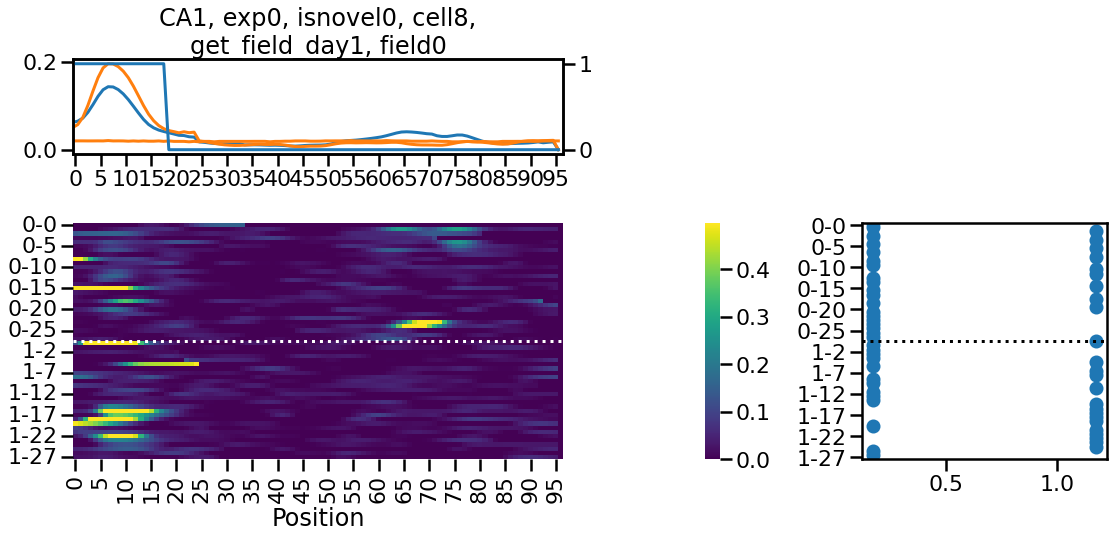

In [159]:
import matplotlib.gridspec as gridspec
fig=plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2, 3, height_ratios=[0.2,0.5],width_ratios=[1,0.03,0.5])
ax00=ax=fig.add_subplot(gs[0, 0])


# fig,axs=plt.subplots(2,2,height_ratios=[0.2,0.5],width_ratios=[0.5,0.2])
# axs[0,1].set_axis_off()
# ax=axs[0,0]
ax.set_title(f'{region}, exp{exp}, isnovel{isnovel}, cell{uid},\nget_field_day{get_field_day}, field{field_id}')
ax.plot(X_df.mean(axis=1))
ax.plot(X_df_field_avg)
# ax.axhline(thresh)
ax.plot(X_v_avg_shuffle_up,c='C1')
ax2=ax.twinx()
ax2.plot(in_field_mask)

# ax=axs[1,0]
ax10=ax=fig.add_subplot(gs[1, 0],sharex=ax00)
cbar_ax = fig.add_subplot(gs[1,1])
fig,ax=ph.heatmap(X_df.T,fig=fig,ax=ax,cbar=True,cmap='viridis',cbar_ax=cbar_ax)
ph.plot_day_on_heatmap(X_df.T,fig=fig,ax=ax,color='w')

fr_within_field_across_trial_allfield = pfdt.get_within_field_fr(X_df,field_bounds_final)

# ax=axs[1,1]
ax=fig.add_subplot(gs[1, 2],sharey=ax10)

for fid,row in fr_within_field_across_trial_allfield.iterrows():
    # toplot=fr_within_field_across_trial_allfield.loc[field_id].groupby(level=0).rolling(5,min_periods=0).mean()
    toplot=(row > thresh).astype(float) + np.random.normal() * 0.1
    # ax=np.log(toplot).plot()
    ax.scatter(toplot.values,np.arange(toplot.shape[0]))
#     ax=toplot.T.plot(style='o',ax=ax)
    fig,ax=ph.plot_day_on_heatmap(toplot,vline=False,hline=True,ax=ax,color='k',fig=fig)
plt.tight_layout()

# aggregate all sessions

In [14]:
import detect_field_within_minus_outside_one_exp as dfwmooe
reload(dfwmooe)

import pickle

In [727]:
res_d = {}
field_bounds_all = {}
threshold_all = {}
in_field_mask_all = {}
out_field_mask_all = {}
all_day_activation_d_all = {}
for i,key in enumerate(dfwmooe.db_grouped):
    res=dfwmooe.main(i,force_reload=False,dosave=False,load_only=True)
    field_bounds_all[key] = res['field_bounds_all']
    threshold_all[key] = res['threshold_all']
    in_field_mask_all[key] = res['in_field_mask_all']
    out_field_mask_all[key] = res['out_field_mask_all']
    all_day_activation_d_all[key] = res['all_day_activation_d_all']

field_bounds_all = pd.concat(field_bounds_all,axis=0)
threshold_all = pd.concat(threshold_all,axis=0)
in_field_mask_all = pd.concat(in_field_mask_all,axis=0)
out_field_mask_all = pd.concat(out_field_mask_all,axis=0)
all_day_activation_d_all = pd.concat(all_day_activation_d_all,axis=0)

res = {
    'field_bounds_all':field_bounds_all,
    'threshold_all':threshold_all,
    'in_field_mask_all':in_field_mask_all,
    'out_field_mask_all':out_field_mask_all,
    'all_day_activation_d_all':all_day_activation_d_all
}
save_data_dir = '/mnt/home/szheng/ceph/place_variability/data/thomas18'
save_data_fn = f'{dfwmooe.SAVE_FN[:-2]}_combined.p'
pickle.dump(res,open(os.path.join(save_data_dir,save_data_fn),'wb'))

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_0/field_detection_median_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_1/field_detection_median_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_3/field_detection_median_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_4/field_detection_median_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_5/field_detection_median_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_6/field_detection_median_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_7/field_detection_median_withinoutsidediff_True.p exists; loading---
/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_8/field_detec

In [16]:
save_data_dir = '/mnt/home/szheng/ceph/place_variability/data/thomas18'
save_data_fn = f'{dfwmooe.SAVE_FN[:-2]}_combined.p'
res=pickle.load(open(os.path.join(save_data_dir,save_data_fn),'rb'))


field_bounds_all=    res['field_bounds_all']
threshold_all=    res['threshold_all']
in_field_mask_all=    res['in_field_mask_all']
out_field_mask_all=    res['out_field_mask_all']
all_day_activation_d_all=    res['all_day_activation_d_all']


# quantification

### one way: use within-outside activation

In [885]:
sw_on_ma,field_not_present_per_trial = pfdt.get_sw_ma(all_day_activation_d_all,1,threshold_all,trial_range=5,field_not_present_frac=0.8,sw='on')
sw_off_ma,_ = pfdt.get_sw_ma(all_day_activation_d_all,0,threshold_all,trial_range=5,field_not_present_frac=0.8,sw='off')

sw_on_ma = sw_on_ma.loc[(slice(None),slice(None),slice(None),slice(None),1)]
sw_off_ma = sw_off_ma.loc[(slice(None),slice(None),slice(None),slice(None),0)]

/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py:434: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_field_allfield=fr_field_allfield.loc[:,('within',day)].dropna(axis=1,how='all')
/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py:434: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_field_allfield=fr_field_allfield.loc[:,('within',day)].dropna(axis=1,how='all')


In [883]:
aa=all_day_activation_d_all.loc[region,exp,isnovel,[uid]]

In [892]:
aa['within']

0                                \
                                    0         1         2         3    
             get_field_day                                             
CA1 8 0 1327 0             0  0.589037  0.190173  0.180466  0.340081   
             1             0  0.659481  0.243418  0.249002  0.411124   

                                                                      \
                                    4         5         6         7    
             get_field_day                                             
CA1 8 0 1327 0             0  0.091799  0.297601  0.238553  0.172278   
             1             0  0.106408  0.291751  0.271843  0.188674   

                                                  ...       1                  \
                                    8         9   ...  29  28  29  30  31  32   
             get_field_day                        ...                           
CA1 8 0 1327 0             0  0.045152  0.077090  ... NaN NaN NaN NaN NaN NaN   
             1             0  0.025116  0.069003  ... NaN NaN NaN NaN NaN NaN   

                                   0          
                              33  30  31  32  
             get_field_day                    
CA1 8 0 1327 0             0 NaN NaN NaN NaN  
             1             0 NaN NaN NaN NaN  

[2 rows x 67 columns]

In [889]:
threshold_all.loc[region,exp,isnovel,uid]

0    0.054414
1    0.032917
dtype: float64

In [888]:
field_not_present_per_trial.loc[region,exp,isnovel,uid]

,,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
get_field_day,,,,,,,,,,,,,,,,,,,,,,
0,0,True,True,True,False,True,True,True,True,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,True,True,True,False,True,True,True,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [893]:
reload(pfdt)
pfdt.get_sw_ma(aa,1,threshold_all,trial_range=5,field_not_present_frac=0.8,sw='on')


/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py:434: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_field_allfield=fr_field_allfield.loc[:,('within',day)].dropna(axis=1,how='all')


> /mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py(442)get_sw_ma()
    440     field_not_present_per_trial = compare
    441     pdb.set_trace()
--> 442     if sw=='on':
    443         sw_ma = field_not_present_per_trial.iloc[:,:trial_range].mean(axis=1) >=field_not_present_frac
    444     elif sw=='off':

ipdb> compare
                                0     1     2      3     4     5     6     7   \
             get_field_day                                                      
CA1 8 0 1327 0             0  True  True  True  False  True  True  True  True   
             1             0  True  True  True  False  True  True  True  True   

                                 8      9      10     11     12     13     14  
             get_field_day                                                     
CA1 8 0 1327 0             0  False   True   True  False  False  False   True  
             1             0  False  False  False  False  False 

BdbQuit: 

In [876]:
field_not_present_per_trial.loc[region,exp,isnovel,uid]

,,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
get_field_day,,,,,,,,,,,,,,,,,,,,,,
0,0,False,False,False,False,False,False,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,False,False,False,False,False,False,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [874]:
sw_on_ma.loc[region,exp,isnovel,uid]

0    True
dtype: bool

In [783]:
gpb=all_day_activation_d_all.groupby(level=(0,1,2),sort=False)
sw_off_ma = []
for k,val in gpb:
    sw_off_ma_one,_=pfdt.get_sw_ma(val,0,threshold_all,trial_range=5,field_not_present_frac=0.8,sw='off')
    sw_off_ma.append(sw_off_ma_one)
sw_off_ma = pd.concat(sw_off_ma,axis=0)
sw_off_ma = sw_off_ma.loc[(slice(None),slice(None),slice(None),slice(None),0)]

/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py:434: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_field_allfield=fr_field_allfield.loc[:,('within',day)].dropna(axis=1,how='all')
/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py:434: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_field_allfield=fr_field_allfield.loc[:,('within',day)].dropna(axis=1,how='all')
/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py:434: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_field_allfield=fr_field_allfield.loc[:,('within',day)].dropna(axis=1,how='all')
/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py:434: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_field_allfield=fr_field_allfield.loc[:,('within'

/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py:434: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_field_allfield=fr_field_allfield.loc[:,('within',day)].dropna(axis=1,how='all')
/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py:434: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_field_allfield=fr_field_allfield.loc[:,('within',day)].dropna(axis=1,how='all')
/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py:434: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_field_allfield=fr_field_allfield.loc[:,('within',day)].dropna(axis=1,how='all')
/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py:434: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_field_allfield=fr_field_allfield.loc[:,('within'

In [787]:
sw_off_ma.loc['CA1'].mean()

0.021698576337751595

In [788]:
sw_on_ma.loc['CA1'].mean()

0.031055713164725055

In [765]:
field_not_present_per_trial.loc[region,exp,isnovel,uid]

0      1      2      3      4      5      6      7   \
get_field_day                                                             
0             0  False  False  False   True   True   True   True   True   
              1   True  False  False  False  False  False  False  False   
1             0  False  False  False   True   True   True   True  False   
              1   True  False  False  False  False  False  False  False   

                    8      9   ...     23     24     25    26     27   28  \
get_field_day                  ...                                          
0             0   True   True  ...  False  False  False  True   True  NaN   
              1  False  False  ...   True   True   True  True   True  NaN   
1             0   True   True  ...  False  False  False  True  False  NaN   
              1  False  False  ...   True  False  False  True  False  NaN   

                  29   30   31   32  
get_field_day                        
0             0  NaN  NaN  NaN  NaN  
              1  NaN  NaN  NaN  NaN  
1             0  NaN  NaN  NaN  NaN  
              1  NaN  NaN  NaN  NaN  

[4 rows x 33 columns]

In [792]:
sw_ma_day_dict = {'on':(sw_on_ma,1,0),'off':(sw_off_ma,0,1)}
# sw_ma_day_dict = {'on':(sw_on_ma,1,0)}

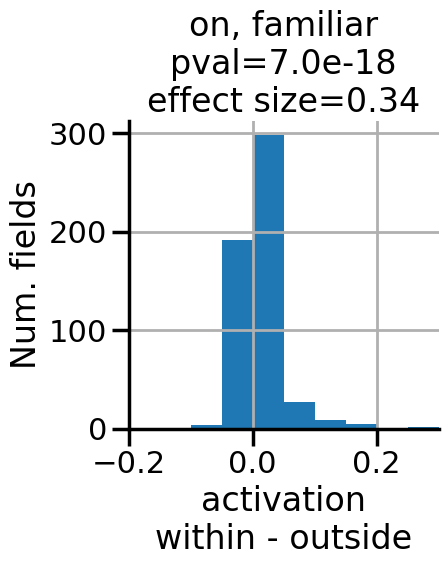

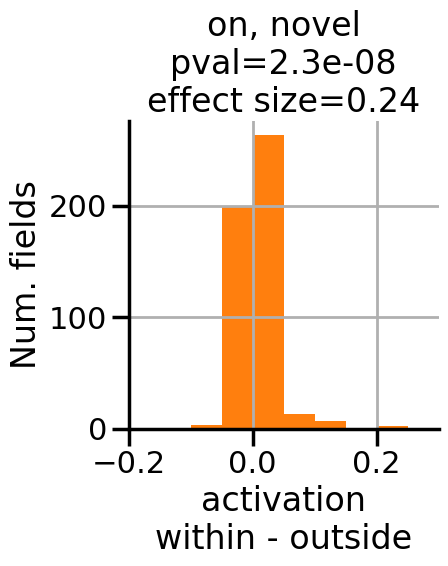

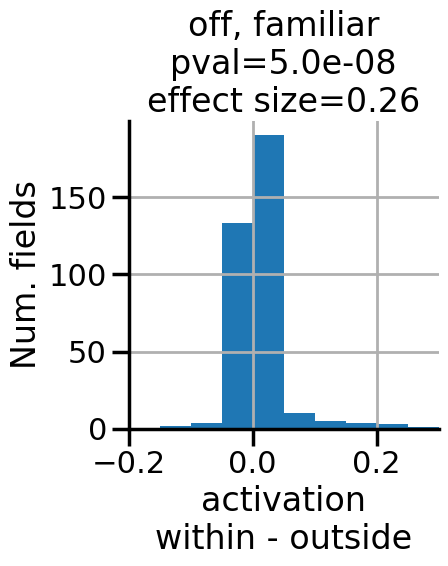

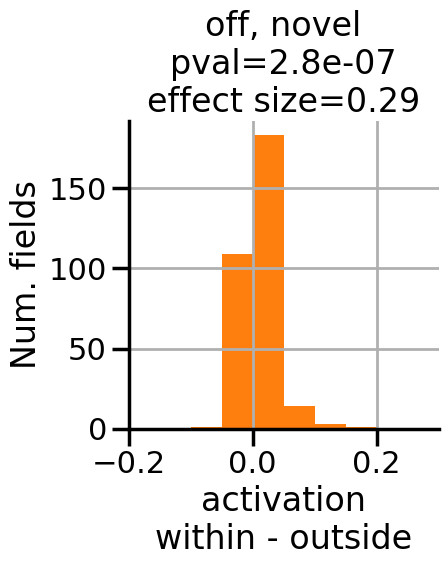

In [796]:
region='CA1'
for sw_k,(sw_ma,get_field_day,other_day) in sw_ma_day_dict.items():
    activation=all_day_activation_d_all.loc[(slice(None),slice(None),slice(None),slice(None),get_field_day)]
    activation_otherday_with_sw = activation.loc[sw_ma,(slice(None),other_day)]
    for isnovel in [0,1]:
        isnovel_key = ['familiar','novel'][isnovel]
        toplot = activation_otherday_with_sw['diff'].loc[region,slice(None),isnovel].mean(axis=1)
        # toplot=diff_norm.loc[region,slice(None),isnovel].mean(axis=1)
        # toplot=diff_norm.loc[region,slice(None),isnovel]
        fig,ax=plt.subplots(figsize=(4,4))
        # ax=toplot.hist(bins=20)
        ax=toplot.hist(bins=np.arange(-0.2,0.31,0.05),color=f'C{isnovel}')
        ax.set_xlim([-0.2,0.3])
        ax.grid(True)
        scipy.stats.wilcoxon(toplot,alternative='greater')
        ax.set_xlabel('activation\nwithin - outside')
        ax.set_ylabel('Num. fields')
        sns.despine()
        _,pval=scipy.stats.wilcoxon(toplot,alternative='greater')
        effect_size = toplot.mean() / toplot.std()
        ax.set_title(f'{sw_k}, {isnovel_key}\npval={pval:.1e}\neffect size={effect_size:.2f}')
        figfn = f'activation_diff_all_fields_sw_{sw_k}_{region}_isnovel{isnovel}_hist'
        ph.save_given_name(fig,figfn,figdir=figdir)

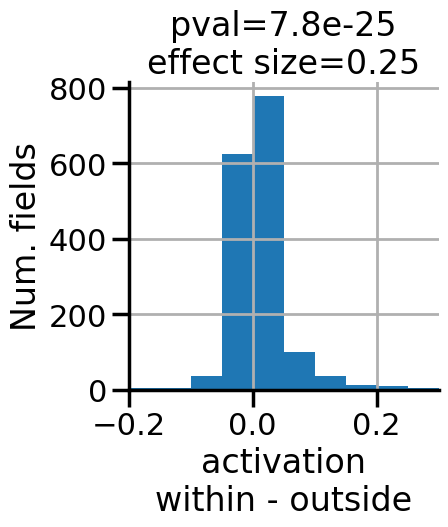

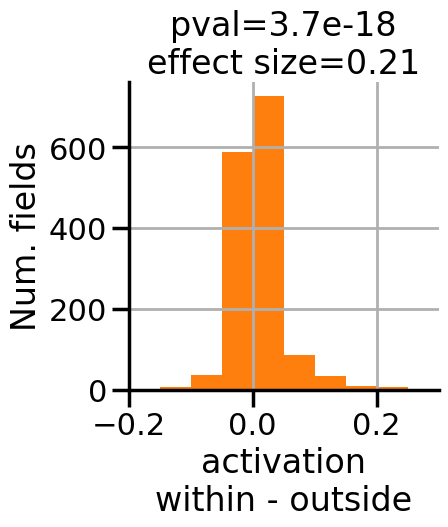

In [585]:
region='CA1'
for isnovel in [0,1]:
    toplot = activation_otherday_with_sw['diff'].loc[region,slice(None),isnovel].mean(axis=1)
    # toplot=diff_norm.loc[region,slice(None),isnovel].mean(axis=1)
    # toplot=diff_norm.loc[region,slice(None),isnovel]
    fig,ax=plt.subplots(figsize=(4,4))
    # ax=toplot.hist(bins=20)
    ax=toplot.hist(bins=np.arange(-0.2,0.31,0.05),color=f'C{isnovel}')
    ax.set_xlim([-0.2,0.3])
    ax.grid(True)
    scipy.stats.wilcoxon(toplot,alternative='greater')
    ax.set_xlabel('activation\nwithin - outside')
    ax.set_ylabel('Num. fields')
    sns.despine()
    _,pval=scipy.stats.wilcoxon(toplot,alternative='greater')
    effect_size = toplot.mean() / toplot.std()
    ax.set_title(f'pval={pval:.1e}\neffect size={effect_size:.2f}')
    figfn = f'activation_diff_all_fields_{region}_isnovel{isnovel}_hist'
    ph.save_given_name(fig,figfn,figdir=figdir)

In [495]:
reload(ph)
sns.set_context('poster')

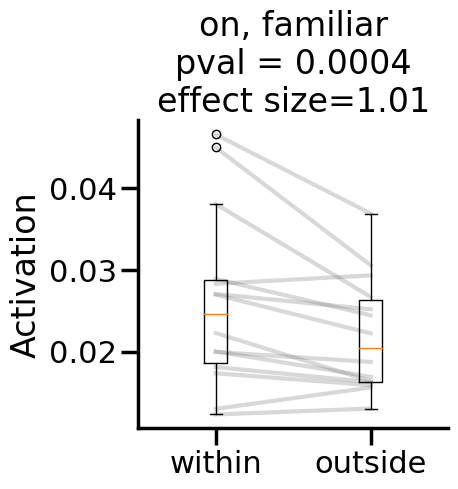

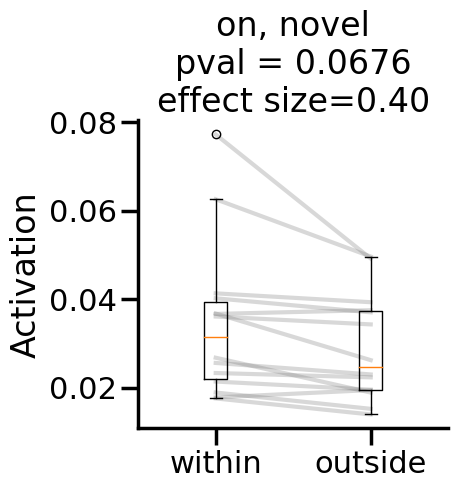

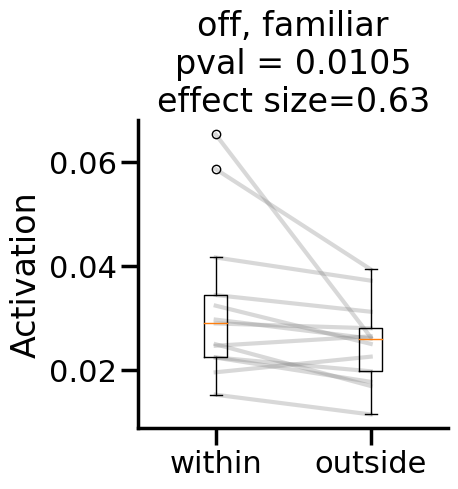

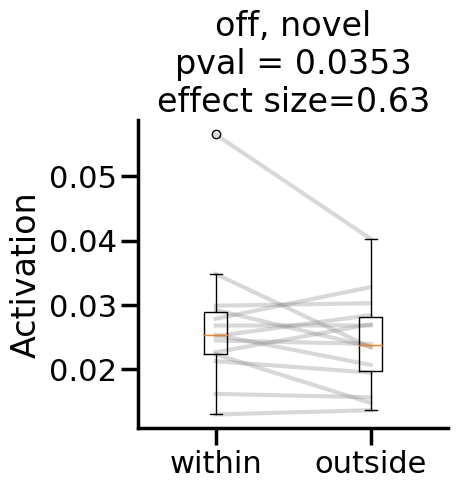

In [803]:
for sw_k,(sw_ma,get_field_day,other_day) in sw_ma_day_dict.items():
    activation=all_day_activation_d_all.loc[(slice(None),slice(None),slice(None),slice(None),get_field_day)]
    activation_otherday_with_sw = activation.loc[sw_ma,(slice(None),other_day)]
    activation_otherday_with_sw_agg=activation_otherday_with_sw.groupby(level=0,axis=1).mean().groupby(level=(0,1,2)).median() # mean across trial, median across fields
    for isnovel in [0,1]:
        isnovel_key = ['familiar','novel'][isnovel]
        toplot=activation_otherday_with_sw_agg.loc[region,slice(None),isnovel]
        fig,ax=plt.subplots(figsize=(4,4))
        fig,ax=ph.box_strip_plot(toplot,x1='within',x2='outside',fig=fig,ax=ax)
        _,pval= scipy.stats.wilcoxon(toplot['diff'])
        effect_size = toplot['diff'].mean() / toplot['diff'].std()
        ax.set_title(f'{sw_k}, {isnovel_key}\npval = {pval:.4f}\neffect size={effect_size:.2f}')
        ax.set_ylabel('Activation')
        figfn=f'sw_{sw_k}_within_outside_box_strip_region{region}_isnovel{isnovel}'
        ph.save_given_name(fig,figfn,figdir=figdir)


In [ ]:
# sw_ma = sw_on_ma
# activation=all_day_activation_d_all.loc[(slice(None),slice(None),slice(None),slice(None),get_field_day)]
# activation_otherday_with_sw = activation.loc[sw_ma,(slice(None),other_day)]
# activation_otherday_with_sw_agg=activation_otherday_with_sw.groupby(level=0,axis=1).mean().groupby(level=(0,1,2)).median()

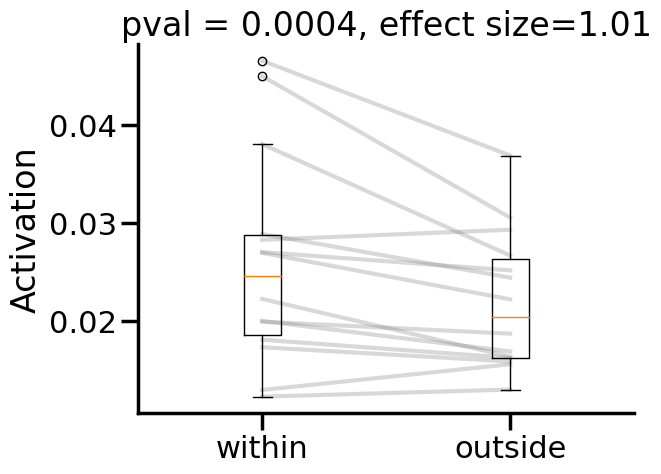

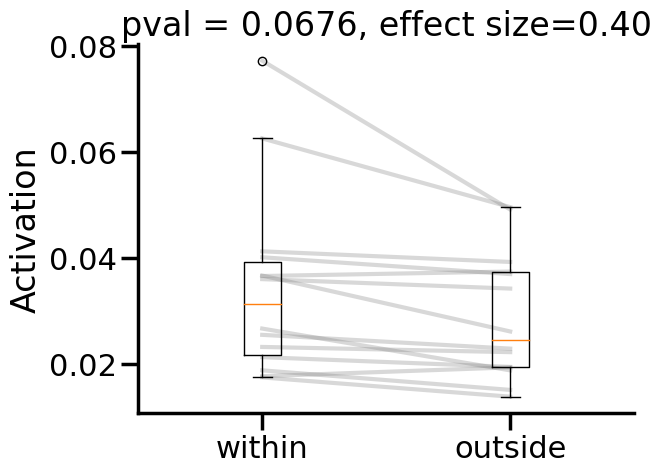

In [735]:
region = 'CA1'

for isnovel in [0,1]:
    toplot=activation_otherday_with_sw_agg.loc[region,slice(None),isnovel]
    fig,ax=ph.box_strip_plot(toplot,x1='within',x2='outside')
    _,pval= scipy.stats.wilcoxon(toplot['diff'])
    effect_size = toplot['diff'].mean() / toplot['diff'].std()
    ax.set_title(f'pval = {pval:.4f}, effect size={effect_size:.2f}')
    ax.set_ylabel('Activation')
    figfn=f'within_outside_box_strip_region{region}_isnovel{isnovel}'
    ph.save_given_name(fig,figfn,figdir=figdir)

In [287]:
region ='CA1'
exp = 14
isnovel=0
activation_otherday_with_sw_oneexp=activation_otherday_with_sw.loc[(region,exp,isnovel),:]
# activation_otherday_with_sw_oneexp=activation_otherday_with_sw.loc[(region,slice(None),isnovel),:]

<Axes: >

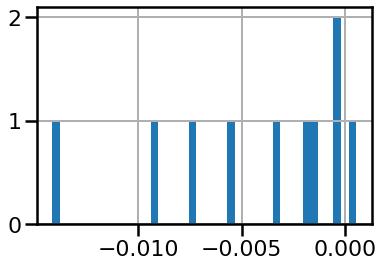

In [288]:
activation_otherday_with_sw_oneexp['diff'].mean(axis=1).hist(bins=40)

In [289]:
scipy.stats.wilcoxon(activation_otherday_with_sw_oneexp['diff'].mean(axis=1),alternative='greater')

WilcoxonResult(statistic=3.0, pvalue=0.9970703125)

### another way: look at field detected on the previous day (not used)

In [871]:
sw_on_ma,field_not_present_per_trial = pfdt.get_sw_ma(all_day_activation_d_all,1,threshold_all,trial_range=5,field_not_present_frac=0.8,sw='on')
sw_off_ma,field_not_present_per_trial = pfdt.get_sw_ma(all_day_activation_d_all,0,threshold_all,trial_range=5,field_not_present_frac=0.8,sw='off')

sw_on_ma = sw_on_ma.loc[(slice(None),slice(None),slice(None),slice(None),1)]
sw_off_ma = sw_off_ma.loc[(slice(None),slice(None),slice(None),slice(None),0)]

/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py:434: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_field_allfield=fr_field_allfield.loc[:,('within',day)].dropna(axis=1,how='all')
/mnt/home/szheng/projects/place_variability/code/thomas_18_data/place_field_detection_thomas.py:434: PerformanceWarning: indexing past lexsort depth may impact performance.
  fr_field_allfield=fr_field_allfield.loc[:,('within',day)].dropna(axis=1,how='all')


In [343]:
slice_one_day = (slice(None),slice(None),slice(None),slice(None),1)
slice_other_day = (slice(None),slice(None),slice(None),slice(None),0)
field_bounds_all_withsw_oneday=field_bounds_all.loc[slice_one_day].loc[sw_on_ma]
ind=field_bounds_all_withsw_oneday.reset_index(level=4).index.unique()
field_bounds_all_withsw_otherday = field_bounds_all.reset_index(level=(4,5)).loc[ind].set_index(['level_4','level_5'],append=True)
field_bounds_all_withsw_otherday = field_bounds_all_withsw_otherday.loc[slice_other_day]

In [463]:
%%time
has_field_other_day_all = {}
field_close_other_day_all = {}
field_overlap_other_day_all = {}
index_to_check=field_bounds_all_withsw_otherday.reset_index(level=4).index
for k,row in field_bounds_all_withsw_oneday.iterrows():
    rr,ee,nn,uu,ff=k
    k_nofield=(rr,ee,nn,uu)
    if k_nofield in index_to_check:
        has_field_other_day_all[k] = True
        tocompare=field_bounds_all_withsw_otherday.loc[k_nofield]
        overlap = np.minimum(row['end'],tocompare['end'])-np.maximum(row['start'],tocompare['start'])  
        overlap[overlap<0] = 0
        span = np.maximum(row['end'],tocompare['end'])-np.minimum(row['start'],tocompare['start'])  
        frac_overlap = overlap / span
        field_overlap=pd.concat({'overlap':overlap,'span':span,'frac_overlap':frac_overlap},axis=1)
        field_overlap_other_day_all[k] = field_overlap.loc[field_overlap['frac_overlap'].idxmax()]
                  
        
        
    else:
        has_field_other_day_all[k] = False
        
    
field_overlap_other_day_all = pd.concat(field_overlap_other_day_all,axis=0).unstack()
has_field_other_day_all = pd.Series(has_field_other_day_all)

CPU times: user 6.57 s, sys: 7.56 ms, total: 6.58 s
Wall time: 6.58 s


<Axes: >

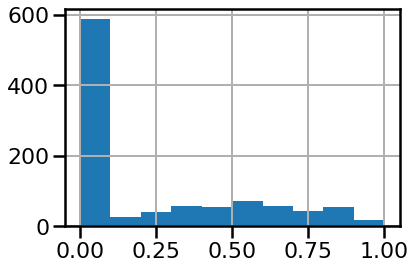

In [464]:
field_overlap_other_day_all.loc['CA1',slice(None),0]['frac_overlap'].hist(bins=10)

In [465]:
field_overlap_vs_thresh = {}
isnovel=0
for fo in [0,0.1,0.3,0.5,0.7]:
    field_overlap_vs_thresh[fo]=(field_overlap_other_day_all.loc['CA1',slice(None),isnovel]['frac_overlap']>fo).mean()
field_overlap_vs_thresh=pd.Series(field_overlap_vs_thresh)



<Axes: >

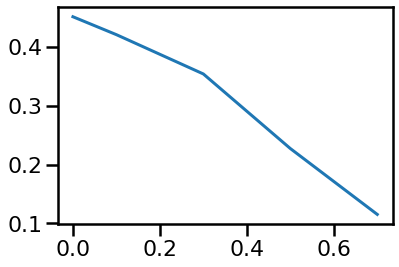

In [466]:
field_overlap_vs_thresh.plot()

In [468]:
region = 'CA1'
isnovel=0
fo_all = field_overlap_other_day_all.loc[region,slice(None),isnovel]['frac_overlap']
ii=2
exp,uid,field_id=fo_all.loc[fo_all==0].index[ii]

# example again

In [831]:
# on example
sw_ma = sw_on_ma
get_field_day = 1
other_day = 0

activation=all_day_activation_d_all.loc[(slice(None),slice(None),slice(None),slice(None),get_field_day)]
activation_otherday_with_sw = activation.loc[sw_ma,(slice(None),other_day)]


In [867]:
activation.loc[region,exp,isnovel,uid]

within                                                              \
          0                                                               
         0         1         2         3         4         5         6    
0  0.659481  0.243418  0.249002  0.411124  0.106408  0.291751  0.271843   

                                 ... diff within         outside         diff  \
                                 ...    1      0               0            0   
         7         8         9   ...   33     30  31  32      30  31  32   30   
0  0.188674  0.025116  0.069003  ...  NaN    NaN NaN NaN     NaN NaN NaN  NaN   

           
           
   31  32  
0 NaN NaN  

[1 rows x 201 columns]

In [865]:
sw_on_ma.loc[region,exp,isnovel,uid]

0    True
dtype: bool

In [897]:
thresh

0.010509929917308496

In [899]:
threshold_all.loc[region,exp,isnovel,uid]

0    0.054414
1    0.032917
dtype: float64

In [946]:
isnovel=0
diff_mean = activation_otherday_with_sw['diff'].mean(axis=1)
diff_mean_sub = diff_mean.loc[(region,slice(None),isnovel)]
ii = 10 # 5
row=diff_mean_sub.loc[diff_mean_sub > 0.1]
print(row.iloc[ii])
exp,uid,field_id=row.index[ii]


X_df = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:][[0,1]].dropna(axis=1,how='all')
# X_df=X_df.fillna(method='ffill',axis=0)
X_df=X_df.fillna(0)
X_df_field = X_df.loc[:,[get_field_day]].dropna(axis=0,how='all').fillna('ffill',axis=0) # 


reload(pfdt)
mean_or_median_across_trial = 'median' # 'mean'#
# field_bounds_final,in_field_mask,out_field_mask,X_df_field_avg,thresh,X_v_avg_shuffle_up  = pfdt.detect_field_using_contiguous_region_with_criteria(X_df_field,baseline_quantile=0.25,max_baseline_diff_frac=0.25,
#                                                        highest=None,baseline=None,mean_or_median_across_trial=mean_or_median_across_trial,
#                                                                 frac_pooled_thresh=0.6,
#                                         min_width=4,in_out_ratio=3.,frac_sig_transient=0.2,
#                                         n_min_roll = 10,nrepeats =1000,up_quantile=0.8,low_quantile=0.1,
#                                                        outfield_frac_pos = 0.1,
#                                                 outfield_frac_size_thresh = 0.05,do_get_window_outside=True,
#                                        )

field_bounds_final,in_field_mask,out_field_mask,X_df_field_avg,thresh,X_v_avg_shuffle_up  = pfdt.detect_field_using_contiguous_region_with_criteria(X_df_field,mean_or_median_across_trial=mean_or_median_across_trial)


# the above code ahs no pooling; using the batch result
field_bounds_final = field_bounds_all.loc[region,exp,isnovel,uid,get_field_day]
thresh = threshold_all.loc[region,exp,isnovel,uid,get_field_day]
in_field_mask = in_field_mask_all.loc[region,exp,isnovel,uid,get_field_day]

0.10982162816248926


In [851]:
import matplotlib.gridspec as gridspec
def plot_ratemap_avg_trial(dosave=False):

    fig=plt.figure(figsize=(8,8))
    # gs = gridspec.GridSpec(2, 3, height_ratios=[0.2,0.5],width_ratios=[1,0.03,0.5])
    gs = gridspec.GridSpec(2, 2, height_ratios=[0.2,0.5],width_ratios=[1,0.5],hspace=0.1,wspace=0.1)
    ax00=ax=fig.add_subplot(gs[0, 0])



    fig.suptitle(f'{region}, exp{exp}, isnovel{isnovel}, cell{uid},\nget_field_day{get_field_day}, field{field_id}',y=1.05)

    ax.plot(X_df_field_avg)
    ax.plot(in_field_mask * X_df_field_avg.max(),linestyle='--',label='field mask',c='C3')

    ax.tick_params(axis='x',labelbottom=False)
    ax.set_title('Trial-averaged ratemap')
    sns.despine()

    # ax=axs[1,0]
    ax10=ax=fig.add_subplot(gs[1, 0],sharex=ax00)
    # cbar_ax = fig.add_subplot(gs[1,1])
    # fig,ax=ph.heatmap(X_df.T,fig=fig,ax=ax,cbar=True,cmap='viridis',cbar_ax=cbar_ax)
    fig,ax=ph.heatmap(X_df.T,fig=fig,ax=ax,cbar=False,cmap='viridis',cbar_ax=cbar_ax)
    npos=X_df.T.shape[1]
    xs = np.arange(0,npos,10)
    ax.set_xticks(xs)
    ax.set_xticklabels(xs,rotation=90)
    ph.plot_day_on_heatmap(X_df.T,fig=fig,ax=ax,color='w')
    ax.set_ylabel('Day-Trial')


    # data needed
    field_bounds_one = field_bounds_final
    window_bounds_one=field_bounds_one[['window_start','window_end']]
    # jitter to avoid overlapping bounds
    jitter=0.5
    window_bounds_one = window_bounds_one.rename(lambda x:x[7:],axis=1) # get rid of window
    window_bounds_one['start'] = window_bounds_one['start'] + jitter
    window_bounds_one['end'] = window_bounds_one['end'] - jitter
    ma = window_bounds_one['end']<field_bounds_one['end']
    window_bounds_one.loc[ma,'end'] = field_bounds_one.loc[ma,'end'] + jitter
    ma = window_bounds_one['start']>field_bounds_one['start']
    window_bounds_one.loc[ma,'start'] = field_bounds_one.loc[ma,'start'] - jitter
    fig,ax=ph.add_field_bounds(field_bounds_one,df=X_df.T,by_day=False,by_previous_day=False,fig=fig,ax=ax,c='C3')
    fig,ax=ph.add_field_bounds(window_bounds_one,df=X_df.T,by_day=False,by_previous_day=False,fig=fig,ax=ax,c='orange')

    fr_within_field_across_trial_allfield = pfdt.get_within_field_fr(X_df,field_bounds_final)

    # ax=axs[1,1]
    # ax=fig.add_subplot(gs[1, 2],sharey=ax10)
    ax=fig.add_subplot(gs[1, 1],sharey=ax10)

    for ii,(fid,row) in enumerate(fr_within_field_across_trial_allfield.iterrows()):
        # toplot=fr_within_field_across_trial_allfield.loc[field_id].groupby(level=0).rolling(5,min_periods=0).mean()
        toplot=(row > thresh).astype(float) + np.random.normal() * 0.1 * ii
        # ax=np.log(toplot).plot()
        ax.scatter(toplot.values,np.arange(toplot.shape[0]),s=4.,label=f'field {ii}')
    #     ax.plot(toplot.values,np.arange(toplot.shape[0]),marker='o',ms=1.)
    #     ax=toplot.T.plot(style='o',ax=ax)
        fig,ax=ph.plot_day_on_heatmap(toplot,vline=False,hline=True,ax=ax,color='k',fig=fig)
    ax.legend(labelspacing=0.5,borderpad=0,handletextpad=0.0,bbox_to_anchor=[1.05,1],frameon=False,markerscale=5)
    ax.set_title('Field activation\nper trial')
    ax.set_xticks([0,1])
    ax.set_xticklabels(['below thresh','above thresh'],rotation=45)
    ax.tick_params(axis='y',labelleft=False)
    # plt.tight_layout()

    figfn=f'rba_sw_ex_{region}_exp{exp}_isnovel{isnovel}_cell{uid}_day{get_field_day}_field{field_id}'
    if dosave:
        ph.save_given_name(fig,figfn,figdir=figdir)

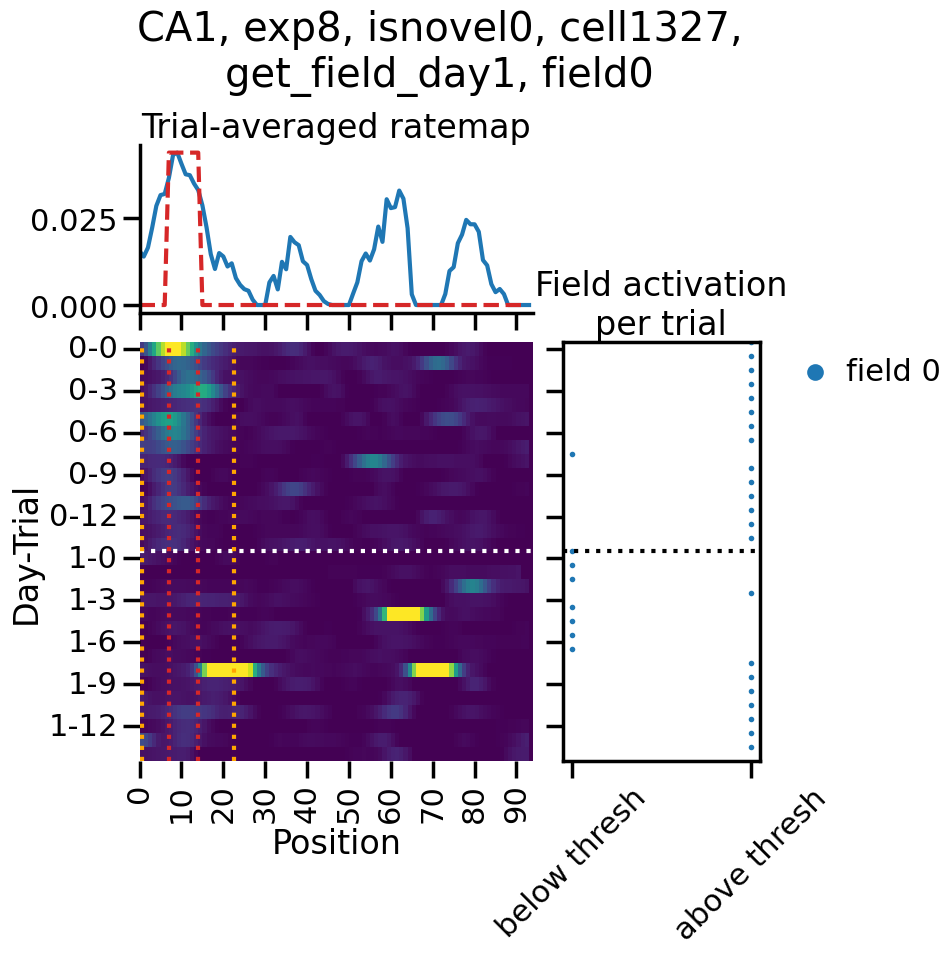

In [947]:
plot_ratemap_avg_trial(False)

In [808]:
# off example
sw_ma = sw_off_ma
get_field_day = 0
other_day = 1

activation=all_day_activation_d_all.loc[(slice(None),slice(None),slice(None),slice(None),get_field_day)]
activation_otherday_with_sw = activation.loc[sw_ma,(slice(None),other_day)]


In [828]:
isnovel=0
diff_mean = activation_otherday_with_sw['diff'].mean(axis=1)
diff_mean_sub = diff_mean.loc[(region,slice(None),isnovel)]
ii = 8 # 5
row=diff_mean_sub.loc[diff_mean_sub > 0.1]
print(row.iloc[ii])
exp,uid,field_id=row.index[ii]


X_df = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:][[0,1]].dropna(axis=1,how='all')
# X_df=X_df.fillna(method='ffill',axis=0)
X_df=X_df.fillna(0)
X_df_field = X_df.loc[:,[get_field_day]].dropna(axis=0,how='all').fillna('ffill',axis=0) # 


reload(pfdt)
mean_or_median_across_trial = 'mean'#'median' # 
field_bounds_final,in_field_mask,out_field_mask,X_df_field_avg,thresh,X_v_avg_shuffle_up  = pfdt.detect_field_using_contiguous_region_with_criteria(X_df_field,baseline_quantile=0.25,max_baseline_diff_frac=0.25,
                                                       highest=None,baseline=None,mean_or_median_across_trial=mean_or_median_across_trial,
                                                                frac_pooled_thresh=0.6,
                                        min_width=4,in_out_ratio=3.,frac_sig_transient=0.2,
                                        n_min_roll = 10,nrepeats =1000,up_quantile=0.8,low_quantile=0.1,
                                                       outfield_frac_pos = 0.1,
                                                outfield_frac_size_thresh = 0.05,do_get_window_outside=True,
                                       )

0.20736204397195135


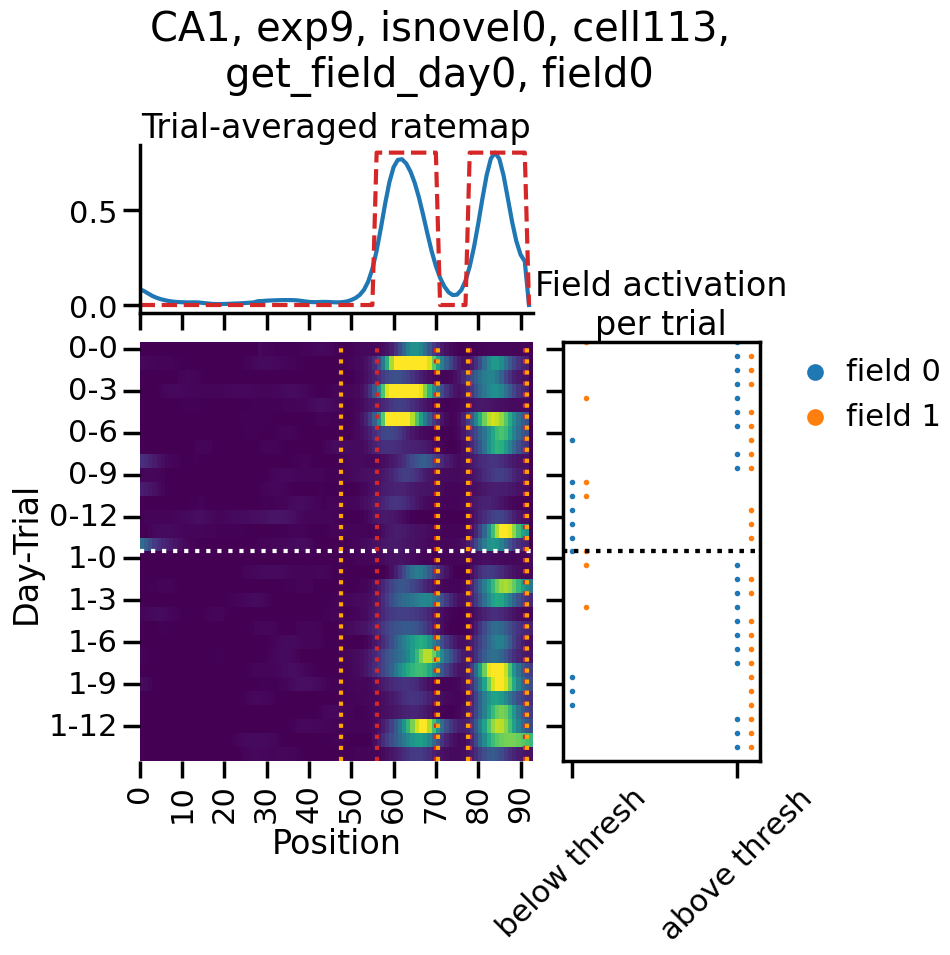

In [830]:
plot_ratemap_avg_trial(True)

In [472]:
field_overlap_other_day_all.loc[region,exp,isnovel,uid]

,overlap,span,frac_overlap
1,0.0,58.0,0.0


In [473]:
field_bounds_all.loc[region,exp,isnovel,uid]

start  end  window_start  window_end
0 0     37   60            28          69
1 0     45   57            36          66
  1     88   95            79          95

In [273]:
sw_on_ma.loc['CA1'].groupby(level=(1)).mean()

0    0.219734
1    0.212576
dtype: float64

In [191]:
sw_on_ma

CA1  0   0  0    0    False
                 1    False
                 2    False
            1    0     True
                 1    False
                      ...  
DG   11  1  210  0    False
                 1     True
            214  0    False
            220  0     True
            221  0    False
Length: 22921, dtype: bool

In [190]:
sw_on_ma.groupby(level=(0,2)).mean()

CA1  0    0.219734
     1    0.212576
CA3  0    0.252125
     1    0.256602
DG   0    0.174419
     1    0.128881
dtype: float64

In [188]:
sw_on_ma.loc['CA1'].groupby(level=(1)).mean()

0    0.219734
1    0.212576
dtype: float64

In [438]:
# datasavedir='/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_8'
# res = {
#     'pre_day_activation_d_all':pre_day_activation_d_all, 
#     'prev_day_silent_ma_d_all':prev_day_silent_ma_d_all,
#     'field_bounds_all':field_bounds_all,
#     'threshold_all':threshold_all
# }
# fn=os.path.join(datasavedir,'field_detection_withinoutsidediff_True_prevdaysilentma.p')
# pickle.dump(res,open(fn,'wb'))

In [439]:
pre_day_activation_d_all_ma_agg = pre_day_activation_d_all.loc[prev_day_silent_ma_d_all].groupby(level=0,axis=1).mean()
pre_day_activation_d_all_agg=pre_day_activation_d_all.groupby(level=0,axis=1).mean()



<Axes: >

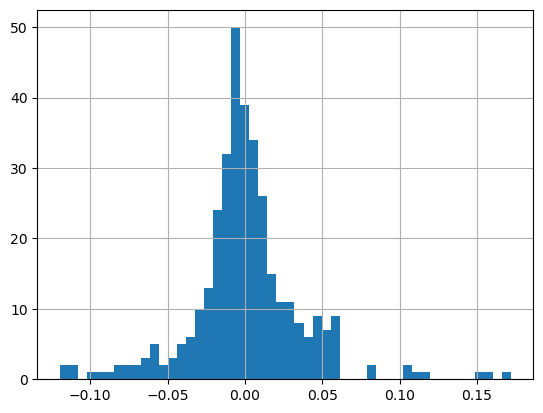

In [440]:
pre_day_activation_d_all_ma_agg['diff'].hist(bins=50)

In [441]:
scipy.stats.wilcoxon(pre_day_activation_d_all_ma_agg['diff'],alternative='greater')

WilcoxonResult(statistic=29958.0, pvalue=0.654798163181263)

In [442]:
def box_strip_plot(df,x1,x2,hue=None,fig=None,ax=None,line_kws={}):
    line_kws_ = {'c':'Grey','alpha':0.3}
    line_kws_.update(line_kws)
    xs = np.arange(2)+1
    if ax is None:
        fig,ax=plt.subplots()
    for i,row in df.iterrows():
        ax.plot(xs,row[[x1,x2]].values,**line_kws_)
    ax.boxplot(df[[x1,x2]].values)
    ax.set_yscale('log')
    sns.despine()
    ax.set_xticklabels([x1,x2])
    return fig,ax
    

WilcoxonResult(statistic=538350.0, pvalue=1.271250247799961e-23)


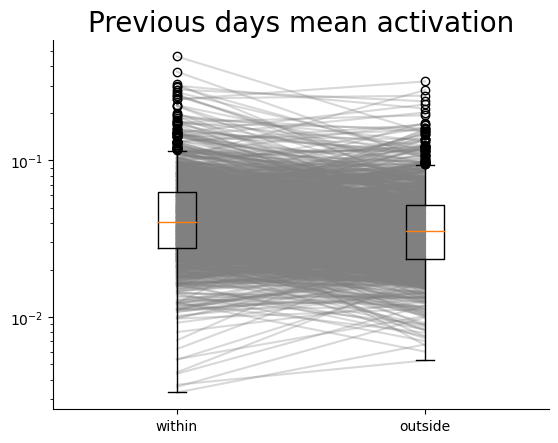

In [443]:
fig,ax=box_strip_plot(pre_day_activation_d_all_agg,x1='within',x2='outside')
print(scipy.stats.wilcoxon(pre_day_activation_d_all_agg['diff'],alternative='greater'))
_=ax.set_title('Previous days mean activation')

WilcoxonResult(statistic=29958.0, pvalue=0.654798163181263)


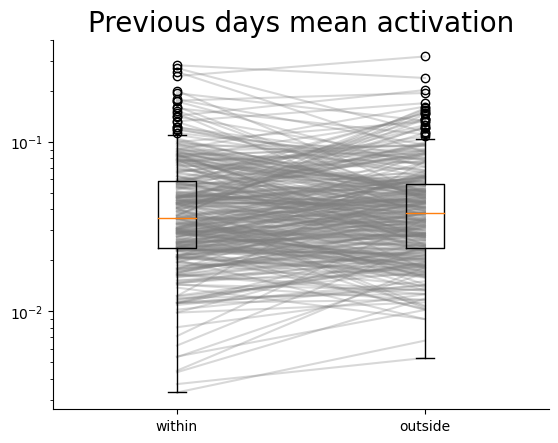

In [444]:
fig,ax=box_strip_plot(pre_day_activation_d_all_ma_agg,x1='within',x2='outside')
print(scipy.stats.wilcoxon(pre_day_activation_d_all_ma_agg['diff'],alternative='greater'))
_=ax.set_title('Previous days mean activation')

In [493]:
ii=2
# row=pre_day_activation_d_all_ma_agg['diff'].sort_values()
row=pre_day_activation_d_all_ma_agg['diff'].sort_values(ascending=False)
# row = pre_day_activation_d_all_ma_agg.loc[pre_day_activation_d_all_ma_agg.index.get_level_values(2)==2]['diff'].sort_values(ascending=False)
print(row.iloc[ii])
isnovel,uid,get_field_day,field_id = row.index[ii]

0.15058895166404226


In [494]:
pre_day_activation_d_all_ma_agg.loc[(isnovel,uid,get_field_day,field_id),:]

diff       0.150589
outside    0.049844
within     0.200433
Name: (0, 1141, 2, 0), dtype: float64

In [495]:
threshold_all.loc[isnovel,uid,2]

0.18602121041982783

In [496]:
(pre_day_activation_d_all.loc[isnovel,uid,get_field_day,field_id]['within'].loc[1].dropna() > threshold_all.loc[isnovel,uid,2]).mean()

0.0

In [497]:
import place_field_detection_thomas as pfdt

In [498]:
# field_bounds_final_allday, in_field_mask_allday,out_field_mask_allday = pfdt.get_field_all_day_per_cell(X_df,pool_days_for_thresh=True)



In [499]:
# field detection one cell
region='CA1'
# exp=0
# uid=9#64
# isnovel=0
# get_field_day=1#2


X_df = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
# X_df=X_df.fillna(method='ffill',axis=0)
X_df=X_df.fillna(0)
X_df_field = X_df.loc[:,[get_field_day]].dropna(axis=0,how='all').fillna('ffill',axis=0) # 

In [500]:
reload(pfdt)
mean_or_median_across_trial = 'median' # 'mean'
field_bounds_final,in_field_mask,out_field_mask,X_df_field_avg,thresh,X_v_avg_shuffle_up  = pfdt.detect_field_using_contiguous_region_with_criteria(X_df_field,baseline_quantile=0.25,max_baseline_diff_frac=0.25,
                                                       highest=None,baseline=None,mean_or_median_across_trial=mean_or_median_across_trial,
                                                                frac_pooled_thresh=0.6,
                                        min_width=4,in_out_ratio=3.,frac_sig_transient=0.2,
                                        n_min_roll = 10,nrepeats =1000,up_quantile=0.8,low_quantile=0.1,
                                                       outfield_frac_pos = 0.1,
                                                outfield_frac_size_thresh = 0.05,do_get_window_outside=True,
                                       )

In [501]:
(X_df_field_avg.max() - X_df_field_avg.quantile(0.25)) * 0.25

0.1492160256071681

In [502]:
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

In [503]:
def get_within_field_fr(X_df,field_bounds_final):
    fr_within_field_across_trial_allfield={}
    for i,row in field_bounds_final.iterrows():
        fr_within_field_across_trial=X_df.loc[row['start']:row['end']].mean(axis=0)
        fr_within_field_across_trial_allfield[i] = fr_within_field_across_trial
    fr_within_field_across_trial_allfield = pd.concat(fr_within_field_across_trial_allfield,axis=1).T
    return fr_within_field_across_trial_allfield

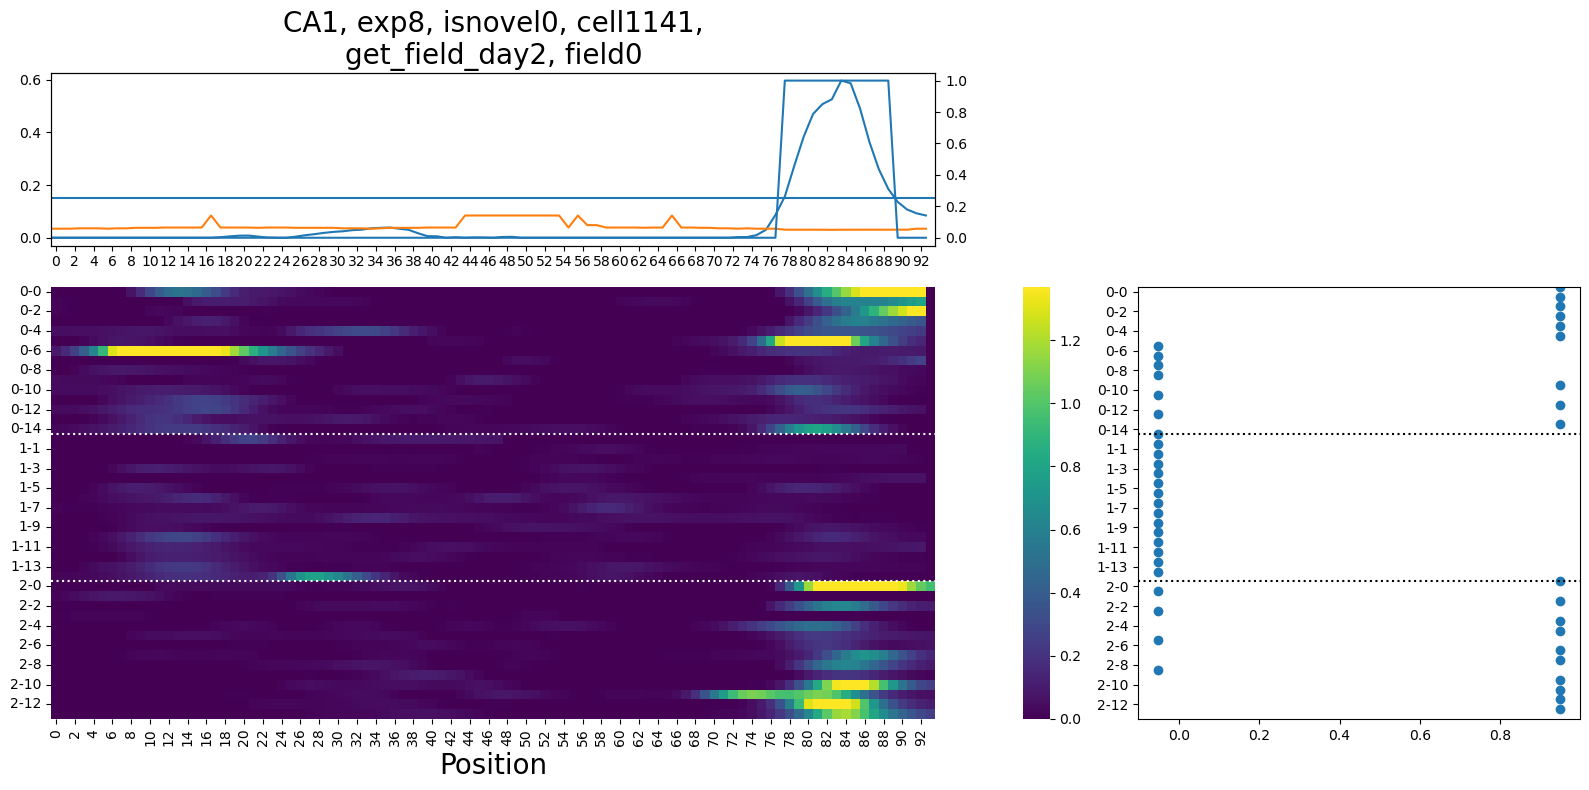

In [504]:
import matplotlib.gridspec as gridspec
fig=plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2, 3, height_ratios=[0.2,0.5],width_ratios=[1,0.03,0.5])
ax00=ax=fig.add_subplot(gs[0, 0])


# fig,axs=plt.subplots(2,2,height_ratios=[0.2,0.5],width_ratios=[0.5,0.2])
# axs[0,1].set_axis_off()
# ax=axs[0,0]
ax.set_title(f'{region}, exp{exp}, isnovel{isnovel}, cell{uid},\nget_field_day{get_field_day}, field{field_id}')
# ax.plot(X_df.mean(axis=1))
ax.plot(X_df_field_avg)
ax.axhline(thresh)
ax.plot(X_v_avg_shuffle_up,c='C1')
ax2=ax.twinx()
ax2.plot(in_field_mask)

# ax=axs[1,0]
ax10=ax=fig.add_subplot(gs[1, 0],sharex=ax00)
cbar_ax = fig.add_subplot(gs[1,1])
fig,ax=ph.heatmap(X_df.T,fig=fig,ax=ax,cbar=True,cmap='viridis',cbar_ax=cbar_ax)
ph.plot_day_on_heatmap(X_df.T,fig=fig,ax=ax,color='w')

fr_within_field_across_trial_allfield = get_within_field_fr(X_df,field_bounds_final)

# ax=axs[1,1]
ax=fig.add_subplot(gs[1, 2],sharey=ax10)

for fid,row in fr_within_field_across_trial_allfield.iterrows():
    # toplot=fr_within_field_across_trial_allfield.loc[field_id].groupby(level=0).rolling(5,min_periods=0).mean()
    toplot=(row > thresh).astype(float) + np.random.normal() * 0.1
    # ax=np.log(toplot).plot()
    ax.scatter(toplot.values,np.arange(toplot.shape[0]))
#     ax=toplot.T.plot(style='o',ax=ax)
    fig,ax=ph.plot_day_on_heatmap(toplot,vline=False,hline=True,ax=ax,color='k',fig=fig)
plt.tight_layout()

In [422]:
reload(pfdt)
pfdt.get_field_all_day_per_cell(X_df,pool_days_for_thresh=True,mean_or_median_across_trial='median')[0]

start  end  window_start  window_end
1 0     41   59            32          68
  1     80   90            71          95
2 0     86   95            77          95

In [196]:
field_bounds_all.loc[isnovel,uid,get_field_day,field_id]

start           22
end             29
window_start    13
window_end      38
Name: (0, 67, 3, 0), dtype: int64

In [216]:
pre_day_activation_d_all.loc[isnovel,uid,get_field_day,field_id]['within'].plot()
pre_day_activation_d_all.loc[isnovel,uid,get_field_day,field_id]['outside'].plot()

KeyError: (1, 295, 3, 1)

In [ ]:
# given field on one day, if the previous day is below threshold, inside - outside for pre-previous days


In [30]:
field_bounds_final

,start,end,window_start,window_end
0,0,16,0,25
1,29,59,20,68


In [36]:
def get_within_outside_field_fr(X_df,field_bounds_final):
    fr_within_field_across_trial_allfield={}
    fr_outside_field_across_trial_allfield = {}
    for i,row in field_bounds_final.iterrows():
        fr_within_field_across_trial=X_df.loc[row['start']:row['end']].mean(axis=0)
        fr_within_field_across_trial_allfield[i] = fr_within_field_across_trial
        
        outside_sum=X_df.loc[row['window_start']:(row['start']-1)].sum(axis=0) + X_df.loc[(row['end']+1):row['window_end']].sum(axis=0)
        outside_size=(row['window_end'] - row['window_start'] + 1) - (row['end'] - row['start'] +1)
        fr_outside_field_across_trial_allfield[i] = outside_sum / outside_size
        
    fr_within_field_across_trial_allfield = pd.concat(fr_within_field_across_trial_allfield,axis=1).T
    fr_outside_field_across_trial_allfield = pd.concat(fr_outside_field_across_trial_allfield,axis=1).T
    fr_field_allfield=pd.concat({'within':fr_within_field_across_trial_allfield,'outside':fr_outside_field_across_trial_allfield,
               'diff':fr_within_field_across_trial_allfield - fr_outside_field_across_trial_allfield
              },axis=1)
    
    return fr_field_allfield

In [37]:
fr_field_allfield = get_within_outside_field_fr(X_df,field_bounds_final)

In [49]:
day = 3
prev_day = day - 1
field_not_present_per_trial = fr_field_allfield.loc[:,('within',prev_day)] < threshold_allday.loc[prev_day]
field_not_present_frac = 0.7
field_not_present_ma = field_not_present_per_trial.mean(axis=1) >= field_not_present_frac


In [40]:
threshold_allday

0    0.079753
1    0.070418
2    0.070418
3    0.117364
dtype: float64

In [26]:
reload(pfdt)
field_bounds_final_allday, in_field_mask_allday, out_field_mask_allday, threshold_allday = pfdt.get_field_all_day_per_cell(X_df,pool_days_for_thresh=True)



In [58]:
reload(pfdt)
pre_day_activation_d, prev_day_silent_ma_d = pfdt.get_within_out_diff_one_cell_all_day_all_field(X_df)

<Axes: >

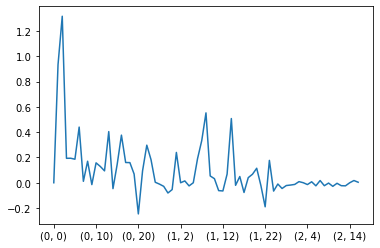

In [67]:
pre_day_activation_d.loc[3,0]['diff'].plot()

In [60]:
prev_day_silent_ma_d

3  0    True
Name: get_field_day, dtype: bool

In [51]:
field_bounds_final_allday

,,start,end,window_start,window_end
0,0,36,60,27,69
1,0,30,42,21,51
3,0,48,58,39,67


In [32]:
threshold_allday

0    0.079753
1    0.070418
2    0.070418
3    0.117364
dtype: float64

In [27]:
threshold_allday

0    0.079753
1    0.070418
2    0.070418
3    0.117364
dtype: float64

In [22]:
fr_within_field_across_trial_allfield

0                                                              \
         0         1         2         3         4         5         6    
0  0.257134  0.177938  1.395614  0.000000  0.214752  0.671961  0.133399   
1  0.003310  0.509950  0.707690  0.169194  0.203591  0.224377  0.191752   

                                 ...         3                                \
         7         8         9   ...        4         5         6         7    
0  0.036117  2.475239  0.062767  ...  0.050616  0.005452  0.000000  0.000000   
1  0.102865  0.158298  0.080648  ...  0.033448  0.443008  0.288783  0.145201   

                                                               
         8         9         10        11        12        13  
0  0.020502  0.005110  0.075591  0.000903  0.011236  0.010069  
1  0.157578  0.156019  0.193047  0.163554  0.201934  0.153475  

[2 rows x 87 columns]

In [196]:
# ratemap corr
mat=X_df.corr().values
np.mean(mat[np.triu_indices(mat.shape[0],k=1)])

0.14900140115862998

In [197]:
field_bounds_final

,start,end,window_start,window_end
0,0,16,0,25
1,29,59,20,68


In [202]:
fr_within_field_across_trial_allfield

0                                                              \
         0         1         2         3         4         5         6    
0  0.257134  0.177938  1.395614  0.000000  0.214752  0.671961  0.133399   
1  0.003310  0.509950  0.707690  0.169194  0.203591  0.224377  0.191752   

                                 ...         3                                \
         7         8         9   ...        4         5         6         7    
0  0.036117  2.475239  0.062767  ...  0.050616  0.005452  0.000000  0.000000   
1  0.102865  0.158298  0.080648  ...  0.033448  0.443008  0.288783  0.145201   

                                                               
         8         9         10        11        12        13  
0  0.020502  0.005110  0.075591  0.000903  0.011236  0.010069  
1  0.157578  0.156019  0.193047  0.163554  0.201934  0.153475  

[2 rows x 87 columns]

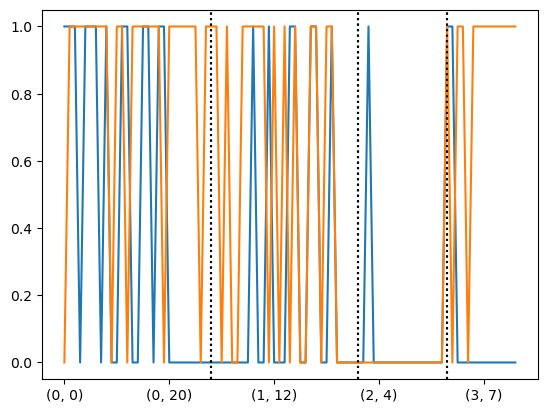

In [56]:
field_bounds_final

,start,end,window_start,window_end
0,0,28,0,37
1,55,64,46,73


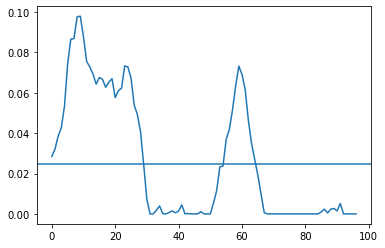

In [55]:
ax=X_df_field_avg.plot()
ax.axhline(thresh)


In [35]:
%%time
region='CA1'
exp=0
fr_map_trial_one_exp = fr_map_trial_df_all_day.loc[(region,exp)].dropna(axis=1,how='all')
field_bounds_one_exp = res['field_bounds_all']

per_field_in_out_activation_all = {}
field_size_all = {}

for ind,row in field_bounds_one_exp.iterrows():
    isnovel,uid,day,field_id=ind
    st,ed=row['start'],row['end']
    field_size=ed - st + 1
    sum_within_field_across_trials_onefield=fr_map_trial_one_exp.loc[(isnovel,uid),:].loc[st:ed].dropna(axis=1,how='all').sum(axis=0)
    mean_within_field_across_trials_onefield = sum_within_field_across_trials_onefield / field_size
    st,ed = row['window_start'],row['window_end']
    window_size = ed - st + 1
    sum_largerwindow_across_trials_onefield=fr_map_trial_one_exp.loc[(isnovel,uid),:].loc[st:ed].dropna(axis=1,how='all').sum(axis=0)
    
    sum_outside_field_across_trials_onefield = sum_largerwindow_across_trials_onefield - sum_within_field_across_trials_onefield
    outside_field_size = window_size - field_size
    mean_outside_field_across_trials_onefield = sum_outside_field_across_trials_onefield / outside_field_size
    
    mean_activation_across_trials_onefield=pd.concat({'in':mean_within_field_across_trials_onefield,'out':mean_outside_field_across_trials_onefield},axis=0)
    per_field_in_out_activation_all[ind] = mean_activation_across_trials_onefield 
    
    field_size_all[ind] = {'in':field_size,'out':outside_field_size}
    
    
per_field_in_out_activation_all = pd.concat(per_field_in_out_activation_all,axis=0)
per_field_in_out_activation_all=per_field_in_out_activation_all.unstack(level=(-3,-2,-1))
field_size_all = pd.DataFrame(field_size_all)
    
    

CPU times: user 27.4 s, sys: 89.1 ms, total: 27.5 s
Wall time: 27.5 s


In [44]:
per_field_diff_all = per_field_in_out_activation_all['in'] - per_field_in_out_activation_all['out']

In [48]:
per_field_diff_all

0                                                    \
                 0         1         2         3         4         5    
0 0   0 0 -0.220091  0.092733 -0.015761  0.063211 -0.009762  0.149365   
        1  0.000000  0.024672  0.049525  0.038096  0.077408  0.081582   
      1 0 -0.205728  0.114357 -0.037116  0.071146 -0.010239  0.192447   
        1  0.000000  0.056153  0.087466  0.052301  0.027392  0.054458   
      2 0  0.177237 -0.065039  0.031384 -0.099540 -0.006596 -0.058595   
...             ...       ...       ...       ...       ...       ...   
1 572 3 0 -0.039042  0.039364 -0.010907 -0.089133  0.043244  0.007480   
  573 1 0 -0.006713 -0.004304  0.042667  0.013523 -0.009721 -0.023680   
        1  0.037519 -0.048201  0.014413 -0.037755 -0.002383  0.003260   
        2 -0.022265 -0.025818 -0.032829  0.007411 -0.016197  0.086206   
      3 0 -0.016240 -0.032233 -0.024416  0.022657 -0.000960  0.085105   

                                                   ...         3            \
                 6         7         8         9   ...        4         5    
0 0   0 0  0.423801  0.201839  0.093940  0.054968  ... -0.078161 -0.081027   
        1 -0.010398  0.265938 -0.030279  0.128687  ...  0.006549  0.047926   
      1 0  0.531294  0.207998  0.096648  0.034248  ... -0.126622 -0.051608   
        1 -0.080463  0.046581 -0.018168  0.008885  ...  0.006549  0.198758   
      2 0 -0.062273  0.091114  0.009710  0.006651  ...  0.305030 -0.248332   
...             ...       ...       ...       ...  ...       ...       ...   
1 572 3 0 -0.030294  0.050928  0.002879  0.013568  ...  0.148302  0.521357   
  573 1 0  0.040759 -0.017195  0.006125 -0.030466  ... -0.017249  0.037738   
        1  0.043013  0.000104 -0.059904 -0.016664  ...  0.024310  0.016122   
        2  0.051970 -0.001677  0.032390 -0.004961  ...  0.130321  0.095151   
      3 0  0.045388  0.023067  0.038255 -0.007658  ...  0.125650  0.087601   

                                                                       \
                 6         7         8         9         10        11   
0 0   0 0 -0.303170 -0.239184 -0.114515  0.114276  0.041381 -0.027286   
        1  0.190223  0.132174  0.012460  0.010480  0.007541  0.020326   
      1 0 -0.083774 -0.120139 -0.050600  0.193950  0.108344 -0.002042   
        1  0.270637  0.193313  0.051160  0.032953  0.091779  0.095488   
      2 0  0.225512  0.168577  0.179170 -0.046771  0.080150  0.068867   
...             ...       ...       ...       ...       ...       ...   
1 572 3 0  0.588505  0.059618  0.295967  0.144017  0.197378       NaN   
  573 1 0  0.029062  0.060121 -0.053495  0.054033 -0.004889       NaN   
        1  0.046670  0.005711  0.010213  0.006253  0.013312       NaN   
        2  0.076589  0.076788  0.397420  0.169842  0.141810       NaN   
      3 0  0.079171  0.065429  0.339408  0.149133  0.141411       NaN   

                               
                 12        13  
0 0   0 0 -0.048940 -0.025785  
        1  0.007414  0.214627  
      1 0 -0.030640 -0.023530  
        1  0.033725  0.406172  
      2 0  0.055031 -0.000033  
...             ...       ...  
1 572 3 0       NaN       NaN  
  573 1 0       NaN       NaN  
        1       NaN       NaN  
        2       NaN       NaN  
      3 0       NaN       NaN  

[7910 rows x 87 columns]

<Axes: xlabel='None-None-None-None', ylabel='None-None'>

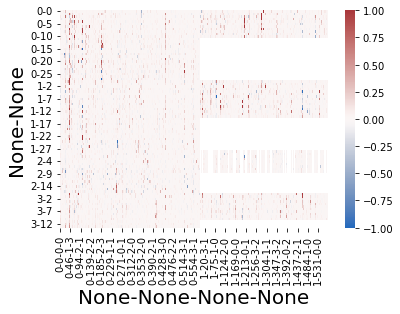

In [51]:
sns.heatmap(per_field_diff_all.T,cmap='vlag',vmin=-1,vmax=1)

(<Figure size 432x288 with 1 Axes>, <Axes: >)

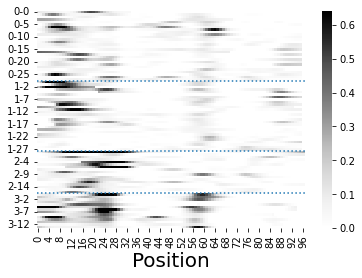

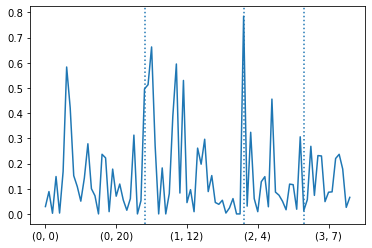

In [16]:
ii=10
# row=per_field_diff_all.iloc[ii]
row=fr_map_trial_one_exp.iloc[ii]
# isnovel,uid,day,field_id=row.name
isnovel,uid,day=row.name
frmap_one=fr_map_trial_one_exp.loc[(isnovel,uid),:].T
fig,ax=ph.heatmap(frmap_one)
ph.plot_day_on_heatmap(frmap_one,fig=fig,ax=ax)
fig=plt.figure()
ax=row.plot()
ph.plot_day_on_heatmap(frmap_one,fig=fig,ax=ax,vline=True,hline=False)

<Axes: >

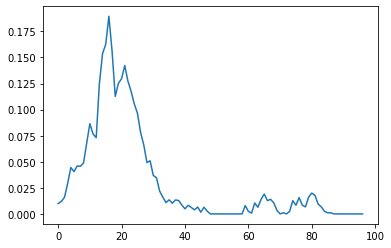

In [20]:
X_df_field_avg.plot()

In [17]:
import place_field_detection_thomas as pfdt
isnovel=0
# uid=
X_df_field = fr_map_trial_one_exp.loc[(isnovel,uid),:].dropna(axis=1)
field_bounds_final,in_field_mask,out_field_mask,X_df_field_avg,thresh,X_v_avg_shuffle_up  = pfdt.detect_field_using_contiguous_region_with_criteria(X_df_field,baseline_quantile=0.25,max_baseline_diff_frac=0.25,
                                                       highest=None,baseline=None,frac_pooled_thresh=0.6,
                                        min_width=4,in_out_ratio=3.,frac_sig_transient=0.2,
                                        n_min_roll = 10,nrepeats =1000,up_quantile=0.8,low_quantile=0.1,
                                                       outfield_frac_pos = 0.1,
                                                outfield_frac_size_thresh = 0.05,do_get_window_outside=True,
                                       )

In [18]:
field_bounds_final

,start,end,window_start,window_end
0,8,29,0,38


(<Figure size 432x288 with 1 Axes>, <Axes: >)

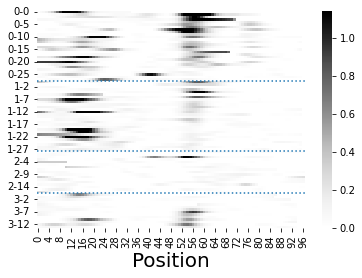

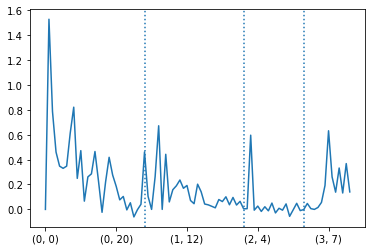

In [76]:
isnovel=0
fr_map_trial_one_exp_fam = fr_map_trial_one_exp.loc[isnovel]

In [117]:
most_active_day=fr_map_trial_one_exp_fam.groupby(level=0).mean().groupby(axis=1,level=(0)).mean().idxmax(axis=1)
ma=most_active_day==2
ii=17
uid=most_active_day.loc[ma].index[ii]

(<Figure size 432x288 with 1 Axes>, <Axes: >)

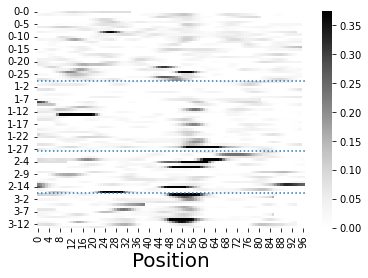

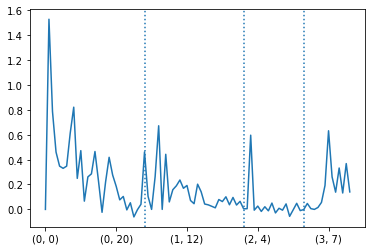

In [118]:
frmap_one=fr_map_trial_one_exp.loc[(isnovel,uid),:].T
fig,ax=ph.heatmap(frmap_one)
ph.plot_day_on_heatmap(frmap_one,fig=fig,ax=ax)
fig=plt.figure()
ax=row.plot()
ph.plot_day_on_heatmap(frmap_one,fig=fig,ax=ax,vline=True,hline=False)

In [14]:
res['field_bounds_all'].loc[0]

start  end  window_start  window_end
0   0 0      4   15             0          24
      1     58   64            49          73
    1 0      5   12             0          21
      1     56   62            47          71
    2 0      9   27             0          36
...        ...  ...           ...         ...
573 1 2     79   89            73          95
    2 0     14   27             5          32
      1     32   74            27          83
    3 0      2   38             0          47
      1     55   71            46          80

[4135 rows x 4 columns]

<Axes: >

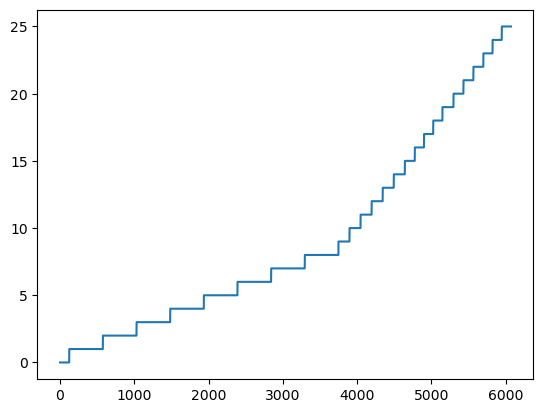

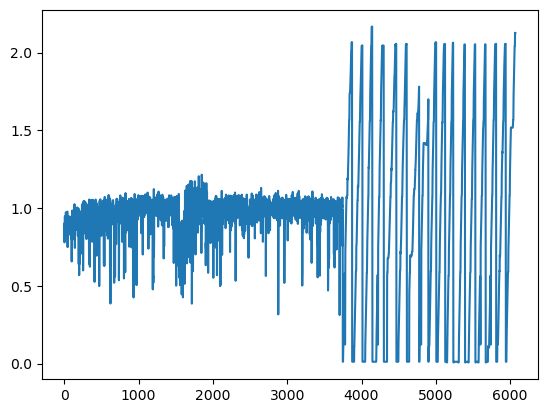

In [506]:
# testing imaging prep issue
ddf='/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/CA1/exp_0/day_2'
fn=os.path.join(ddf,'preprocessed.p')
preprocessed=pickle.load(open(fn,'rb'))

preprocessed['spk_beh_df'].query('task_index==0')['trial'].plot()
plt.figure()
preprocessed['spk_beh_df'].query('task_index==0')['lin'].plot()